# Object Detection using HOG + SVM

In the previous module we learned how to use HOG descriptor with SVM to train a classifier. In this module we will learn how to use a HOG + SVM  classifier for Object Detection. 

# Object Detection 

At the heart of every object detector is a classifier. The core idea of object detector is simply applying the classifier to different image patches of the image. 

The image below is a typical output of a pedestrian detection system. 

<center><img src="https://www.learnopencv.com/wp-content/uploads/2019/09/cv1-week8-object-detection.jpg" width=500/></center>

<center>Figure 1: Typical result of pedestrian / human detection.</center> 


&nbsp;
Unlike a classifier that acts on the entire image, in object detection we need to find the location of the object in the image. Here are a few things to keep in mind while thinking about object detection. 

1. **Location:** The object we are trying to detect can appear at any location in an image. 

2. **Scale:** The scale or the size of the object can be arbitrary. In the Dalal and Triggs paper, the pedestrian detector was trained for an image patch of size 64 x 128. However, a pedestrian can appear in an image in any size. In the above image, the two detected runners have very different scale. We also need to choose the smallest size of the object we are interested in. In the image above, we are probably not interested in tiny runners in the background. 

3. **Rotation:** The object may not be upright. It may be need to be rotated. 

4. **Non-Maximum Supression:** Finally, object detection often requires a post processing step called non-maximum supression. If an object is detected at a particular pixel location, there is a chance it will be detected again at a nearby pixel location. Both these bounding boxes point to the same object and therefore we simply need to rejected overlapping bounding boxes. This is called non-maximum supression. 

## Scale space search

Detecting objects at multiple scales is equivalent to resizing the image and using the fixed sized detector on the resized image. So, object detectors create an image pyramid internally. The image pyramid needs two parameters. 

1. Levels: The number of levels in the pyramid. A typical number is 64. 

2. Scale: How much the image is resized between the levels of the pyramid. A typical number is 1.05. 

In most implementations of an object detector, the image is downscaled and never upscaled. If the object in your image is expected to be tiny, you should upscale the image before sending it to the object detector and resize the rectangles obtained. 

## Location search

Next, we perform a **sliding window search** for the location of the object in every image in the pyramid. The object is assumed to be the same size it was trained on. For example, while looking for pedestrians, we search for pedestrians of size 64 x 128 only because no matter what the actual size of the pedestrian, at least one image in the pyramid will have the pedestrian at size 64 x 128.

<table>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/slidingWindowDetector1.png" /></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m3-SlidingWindowDetector2.png"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m3-slidingWindowDetector3.png"/></center></th>
    </tr>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m3-SlidingWindowDetector4.png"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m3-SlingWindowDetector5.png"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-SlidingWindowDetector6.png"/></center></th>
    </tr>
    <tr>
        <td colspan="3"><center>Figure 2: Sliding window detector. The first row shows the sliding window detector applied to the full scale image. The second row shows a scaled down image. In both cases, the size of the detector ( red box ) is the same.</center></td>
        
</table>

&nbsp;
The first row of Figure 2, shows the sliding window search for image at the highest scale. First, the classifier is run on the top left corner of the image. Then it is moved by a certain amount (called stride), and the classifier is run again to check if the current window has an object. Typically, the stride is set to a fourth or an eighth of the object size. For pedestrian detection, where the window size is 64 x 128, the stride is usually set to 8 x 8. 

The second row of Figure 2, shows the same process being repeated on a different image of the pyramid. Note, this image is resized version of the image the first row, but the size of the window (red box) is the same. 

<table>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m3-objectDetection1.png"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m3-objectDetection2.png"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m3-objectDetection3.png"/></center></th>
    </tr>
    <tr>
        <td colspan="3"><center>Figure 3: Objects are detected in different scaled images. The results are merged to produce the final output.</center> 
</td>
    </tr>
</table>

Different sized objects will be detected in different scaled images as shown in Figure 3. 

Notice the biggest object is detected in a much lower resolution image. The number of search locations is proportional to the square of the scale used. For example, if we are searching for 10,000 locations at scale 1, we have to search for only 2500 locations in scale 0.5 and only 625 locations at scale 0.25. If the object is large, significant computational effort is spent searching at larger scales. Significant speedups can therefore be obtained by correctly resizing the image when you have an idea about the size of the object in the image and the size at which the object detector was trained. If you are building a webcam or selfie application that uses face detection, you can significantly improve speed by resizing the image to the appropriate size. 


## Classifying a patch

From the previous subsection, we know many patches of the image at many locations and scale are evaluated to check if there is an object inside the patch. 

The evaluation is done using the classifier that is able to classify a patch into object vs. background. When an SVM is used as a classifier, the two classes are labeled as -1 (background) and 1 (object). When the response for the SVM classifier is greater than 0, the patch has a greater probability of belonging to the object class. In practice, if the SVM classifier response is greater than a threshold (called the **hitTreshold** in OpenCV) we say it is an object.  A high hitTreshold would result in fewer detected objects. 

## Grouping Rectangles ( non-maximum Suppression )

As mentioned before, the detector may detect multiple rectangles for the same object. Grouping of these rectangles is referred to **non-maximum suppression**. 

We know from the previous section, each bounding box has an associated SVM response. These responses are often called **weights.** The greater the weights, the more likely it is that the box contains an object. 

The goal of non-maximum suppression is to come up with a smaller list of rectangles and a weight associated with every rectangle in the final list. 

There are many different ways of doing non-maximum suppression. In OpenCV, the following steps are employed by the HOG::groupRectangles method internally. 

 

1. **Clustering**: Rectangles are clustered based on overlap between rectangles. The idea is to represent an entire cluster with just one rectangle. 

    1. **Pruning:** If the number of rectangles in a cluster are less than a threshold, the cluster is removed. 

    2. **Cluster average:** The average of all rectangles in every cluster is found. This rectangle is added to  the final list. 

    3. **Pick maximum SVM response:** The SVM response (weight) associated with this average rectangle is the maximum of the weights of all rectangles in the cluster.  

2. **Filtering smaller rectangles:** The final list is further pruned by removing smaller rectangles inside larger ones if the number of rectangles in the original cluster was less than 3. 

**Note:** From the above description, we can see that not all rectangles completely contained inside another rectangle are moved by OpenCV’s non-maximum suppression. 

# HOG + SVM based Object Detection using OpenCV

In this section, we will learn the methods of the HOGDescriptor class that are useful of using a trained HOG classifier as a detector. 

In [2]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0,10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## How to train HOG + SVM Pedestrian Detector

In this section we will learn how to train a HOG + SVM based object detector. We will train a People Detector using INRIA’s Pedestrian dataset. The folder contains two sub-folders - 
1. train_64x128_H96 - contains the cropped images of pedestrians and resized to 64x128 ( Positive Examples )
1. test_64x128_H96 - contains cropped images which do not contain pedestrians. ( Negative Examples )

The training data can also be downloaded from **[this link](https://www.filepicker.io/api/file/VQKdmzKqSLWruVhx7Xdd)**. Please unzip the file INRIAPerson.zip and keep it in the `../data/images/` folder before running the code if it is not already present.

## Data Handling utilities

Functions to read images from a given directory and return their corresponding labels (+1 or -1)

In [8]:
# returns image paths in given folder
# with extensions as defined in imgExts
def getImagePaths(folder, imgExts):
  imagePaths = []
  for x in os.listdir(folder):
    xPath = os.path.join(folder, x)
    if os.path.splitext(xPath)[1] in imgExts:
      imagePaths.append(xPath)
  return imagePaths


# read images in a folder
# return list of images and labels
def getDataset(folder, classLabel):
  images = []
  labels = []
  imagePaths = getImagePaths(folder, ['.jpg', '.png', '.jpeg'])
  for imagePath in imagePaths:
    # print(imagePath)
    im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
    images.append(im)
    labels.append(classLabel)
  return images, labels

## Setup SVM Classifier

Wrappers around SVM functions to initialize SVM, train on data and labels, predict labels and evaluate model’s error rate on test data

In [9]:
# Initialize SVM with parameters
def svmInit(C, gamma):
  model = cv2.ml.SVM_create()
  model.setGamma(gamma)
  model.setC(C)
  model.setKernel(cv2.ml.SVM_LINEAR)
  model.setType(cv2.ml.SVM_C_SVC)
  model.setTermCriteria((cv2.TERM_CRITERIA_EPS + 
                         cv2.TERM_CRITERIA_MAX_ITER, 
                         1000, 1e-3))
  return model


# Train SVM on data and labels
def svmTrain(model, samples, labels):
  model.train(samples, cv2.ml.ROW_SAMPLE, labels)


# predict labels for given samples
def svmPredict(model, samples):
  return model.predict(samples)[1]


# evaluate a model by comparing
# predicted labels and ground truth
def svmEvaluate(model, samples, labels):
  labels = labels[:, np.newaxis]
  pred = model.predict(samples)[1]
  correct = np.sum((labels == pred))
  err = (labels != pred).mean()
  print('label -- 1:{}, -1:{}'.format(np.sum(pred == 1), 
          np.sum(pred == -1)))
  return correct, err * 100


# create a directory if it doesn't exist
def createDir(folder):
  try:
    os.makedirs(folder)
  except OSError:
    print('{}: already exists'.format(folder))
  except Exception as e:
    print(e)

## Setup HoG Feature Detector

Functions to compute HOG descriptors for a set of images and convert HOG descriptor to data format used by SVM


In [10]:
# compute HOG features for given images
def computeHOG(hog, images):
  hogFeatures = []
  for image in images:
    hogFeature = hog.compute(image)
    hogFeatures.append(hogFeature)
  return hogFeatures


# Convert HOG descriptors to format recognized by SVM
def prepareData(hogFeatures):
  featureVectorLength = len(hogFeatures[0])
  data = np.float32(hogFeatures).reshape(-1, featureVectorLength)
  return data

Initialize HOG with parameters


In [11]:
# Initialize HOG parameters
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                      cellSize, nbins,derivAperture,
                      winSigma, histogramNormType, L2HysThreshold, 
                      gammaCorrection, nlevels,signedGradient)

## Setup Training and Testing Modes 

Boolean flags to switch on/off training/testing/query



In [12]:
# Flags to turn on/off training or testing
trainModel = True
testModel = True
queryModel = True

We are using INRIA’s pedestrian dataset to train our model. INRIA comes with train and test folders. Each of these train/test folders have pos and neg folder which contain positive and negative images. Since SVM is trained using vectors of same size, we have created same sized patches from pos and neg directories to posPatches and negPatches. negPatches contain 10 randomly selected patches from each image in neg directory. posPatches contains 1 patch for each image in pos directory after removing the padding (16 for train and 3 for test).

In [13]:
# Path to INRIA Person dataset
rootDir = DATA_PATH + 'images/INRIAPerson/'

# set Train and Test directory paths
trainDir = os.path.join(rootDir, 'train_64x128_H96')
testDir = os.path.join(rootDir, 'test_64x128_H96')

## Training

Read images from posPatches and negPatches directories and create vector of labels corresponding to them. +1 for pos and -1 for neg. Finally we merge image vectors and labels by keeping negative samples after positive samples.

In [14]:
# ================================ Train Model =====================
if trainModel:
    # Read images from Pos and Neg directories
    trainPosDir = os.path.join(trainDir, 'posPatches')
    trainNegDir = os.path.join(trainDir, 'negPatches')

    # Label 1 for positive images and -1 for negative images
    trainPosImages, trainPosLabels = getDataset(trainPosDir, 1)
    trainNegImages, trainNegLabels = getDataset(trainNegDir, -1)

    # Check whether size of all positive and negative images is same
    print(set([x.shape for x in trainPosImages]))
    print(set([x.shape for x in trainNegImages]))

    # Print total number of positive and negative examples
    print('positive - {}, {} || negative - {}, {}'
        .format(len(trainPosImages),len(trainPosLabels),
        len(trainNegImages),len(trainNegLabels)))

    # Append Positive/Negative Images/Labels for Training
    trainImages = np.concatenate((np.array(trainPosImages), 
                       np.array(trainNegImages)), 
                                  axis=0)
    trainLabels = np.concatenate((np.array(trainPosLabels), 
                       np.array(trainNegLabels)),
                                  axis=0)
    # Now compute HOG features for training images and 
    # convert HOG descriptors to data format recognized by SVM.
    # Compute HOG features for images
    hogTrain = computeHOG(hog, trainImages)

    # Convert hog features into data format recognized by SVM
    trainData = prepareData(hogTrain)

    # Check dimensions of data and labels
    print('trainData: {}, trainLabels:{}'
            .format(trainData.shape, trainLabels.shape))
    # Finally create an SVM object, train the model and save it.
    # Initialize SVM object
    model = svmInit(C=0.01, gamma=0)
    svmTrain(model, trainData, trainLabels)
    model.save('pedestrian.yml')

{(128, 64, 3)}
{(128, 64, 3)}
positive - 2416, 2416 || negative - 12180, 12180
trainData: (14596, 3780), trainLabels:(14596,)


## Testing
Load trained model from disk

In [15]:
# ================================ Test Model ===============
if testModel:
    # Load model from saved file
    model = cv2.ml.SVM_load('pedestrian.yml')
    # We will evaluate our test dataset for positive and 
    # negative images separately to calculate True/False Positives 
    # and True/False Negatives
    testPosDir = os.path.join(testDir, 'posPatches')
    testNegDir = os.path.join(testDir, 'negPatches')
    # We will follow the same flow to prepare data as we did for training images.
    # Label 1 for positive images and -1 for negative images
    testPosImages, testPosLabels = getDataset(testPosDir, 1)
    testNegImages, testNegLabels = getDataset(testNegDir, -1)

    # Compute HOG features for images
    hogPosTest = computeHOG(hog, np.array(testPosImages))
    testPosData = prepareData(hogPosTest)
    
    # Run classification on test data for positive images 
    # and calculate True Positives and False Positives.
    posCorrect, posError = svmEvaluate(model, testPosData, 
                                       np.array(testPosLabels))

    # Calculate True and False Positives
    tp = posCorrect
    fp = len(testPosLabels) - posCorrect
    print('TP: {}, FP: {}, Total: {}, error: {}'
            .format(tp, fp, len(testPosLabels), posError))
    # Similarly run classification on negative test data 
    # and calculate True and False Negatives
    # Test on negative images
    hogNegTest = computeHOG(hog, np.array(testNegImages))
    testNegData = prepareData(hogNegTest)
    negCorrect, negError = svmEvaluate(model, testNegData, 
                                       np.array(testNegLabels))

    # Calculate True and False Negatives
    tn = negCorrect
    fn = len(testNegData) - negCorrect
    print('TN: {}, FN: {}, Total: {}, error: {}'
            .format(tn, fn, len(testNegLabels), negError))
    # Calculate Precision and Recall
    precision = tp * 100 / (tp + fp)
    recall = tp * 100 / (tp + fn)
    print('Precision: {}, Recall: {}'.format(precision, recall))

label -- 1:1064, -1:62
TP: 1064, FP: 62, Total: 1126, error: 5.506216696269982
label -- 1:18, -1:4512
TN: 4512, FN: 18, Total: 4530, error: 0.3973509933774834
Precision: 94.49378330373001, Recall: 98.33641404805915


## Testing the model on a new image 
We want to load the SVM models trained by us and use it to find pedestrians in a new image. For this, we need to use the function detectMultiScale present in OpenCV. 

## Usage of hog.**detectMultiScale**

Once the classifier is loaded into the detector, the function **detectMultiScale** is used to detect objects in an image.


### Function Syntax

```python
(foundLocations, foundWeights) = hog.detectMultiScale(img, hitThreshold=hitThreshold, winStride=winStride, padding=padding, scale=scale,  finalThreshold=finalThreshold, useMeanshiftGrouping=useMeanshiftGrouping)
```

where

- **`img`** = Input image.

- **`foundLocations`** = A vector of rectangles corresponding to detected objects.

- **`foundWeights`** = SVM response (weights) associated with the above bounding boxes. You can treat this weight as a measure of confidence.

- **`hitThreshold`** = The SVM response threshold above which we say the rectangle is an object. Usually, the default value of 0 is good. Note elements of foundWeights will always be greater than hitThreshold.

- **`winStride`** = The stride of the object detection window as explained in the Location search subsection above.

- **`padding`** = Padding added to the entire image so objects near the boundary can be detected. Usually this is set to half the detection window width. E.g. in pedestrian detection where the detection window has size 64 x 128, the padding is set to 32 x 32.

- **`scale`** = To create the image pyramid, the image at a level is scaled down by this number. E.g. when scale is set to 1.05, it means that second level of of the pyramid is created by resizing the original image by a factor of 1/1.05. The third level is created by rescaling the image at level 2 by a factor of 1/1.05 and so on.

- **`finalThreshold`** = A better name for this parameter would have been groupThreshold. In the non-maximum suppression step, this parameter is used to prune out clusters that have fewer than finalTreshold number of rectangles.

- **`useMeanshiftGrouping`** = Use the non-standard grouping algorithm based on meanshift. Based on reading the code and the documentation, it is not clear when this is a good idea.

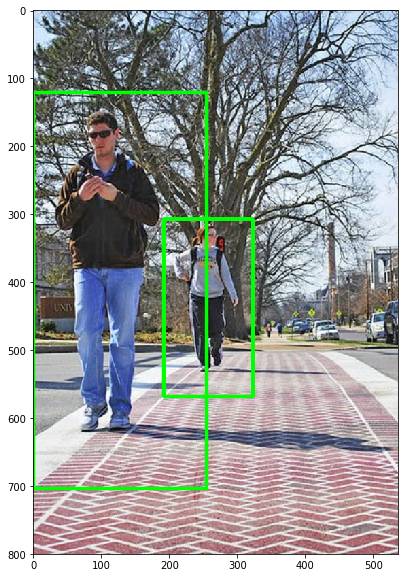

In [16]:
# ================================ Query Model =============================================
# Run object detector on a query image to find pedestrians
# We will load the model again and test the model
# This is just to explain how to load an SVM model
# You can use the model directly
if queryModel:
    # load model
    model = cv2.ml.SVM_load(DATA_PATH + 'models/pedestrian.yml')
    # extract support vector and rho(bias) from model
    sv = model.getSupportVectors()
    rho, aplha, svidx = model.getDecisionFunction(0)
    svmDetector = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
    svmDetector[:-1] = -sv[:]
    svmDetector[-1] = rho

    # set our SVMDetector in HOG
    hog.setSVMDetector(svmDetector)

    filename = DATA_PATH + "images/pedestrians/3.jpg"
    queryImage = cv2.imread(filename, cv2.IMREAD_COLOR)

    # We will run pedestrian detector at an fixed height image
    finalHeight = 800.0
    scale = finalHeight / queryImage.shape[0]
    queryImage = cv2.resize(queryImage, None, fx=scale, fy=scale)

    # detectMultiScale will detect at nlevels of image by scaling up
    # and scaling down resized image by scale of 1.05
    bboxes, weights = hog.detectMultiScale(queryImage, winStride=(8, 8),
                                           padding=(32, 32), scale=1.05,
                                           finalThreshold=2, hitThreshold=1.0)
    # draw detected bounding boxes over image
    for bbox in bboxes:
      x1, y1, w, h = bbox
      x2, y2 = x1 + w, y1 + h
      cv2.rectangle(queryImage, (x1, y1), (x2, y2),
                    (0, 255, 0), thickness=3, lineType=cv2.LINE_AA)
    plt.imshow(queryImage[:,:,::-1])
    plt.show()

## Comparison of our trained model with OpenCV's Pedestrian Detector

We have so far tested our model on 64x128 image patches. Now we will run our model on some real life images. We will also compare our results with OpenCV’s default People Detector. OpenCV’s people detector is also trained on INRIA dataset. We will draw Green rectangles for results from our model and red boxes for results from OpenCV’s people detector.

In [17]:
# Initialize HOG
# Initialize HOG parameters
winSize = (64, 128)
blockSize = (16, 16)
blockStride = (8, 8)
cellSize = (8, 8)
nbins = 9
derivAperture = 1
winSigma = -1
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = True
nlevels = 64
signedGradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                        cellSize, nbins, derivAperture,
                        winSigma, histogramNormType, L2HysThreshold,
                        gammaCorrection, nlevels, signedGradient)

Load model, extract support vectors and decision function (rho) from this model. Now create a SVM detector for HOG by appending rho at the end of support vectors. Now set this SVM detector in HOG.



In [18]:
# Load model trained by us
model = cv2.ml.SVM_load('pedestrian.yml')
sv = model.getSupportVectors()
rho, aplha, svidx = model.getDecisionFunction(0)
svmDetectorTrained = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
svmDetectorTrained[:-1] = -sv[:]
svmDetectorTrained[-1] = rho
# set SVMDetector trained by us in HOG
hog.setSVMDetector(svmDetectorTrained)

Initialize HOG and set OpenCV’s default People Detector as SVM detector in HOG.



In [19]:
# OpenCV's HOG based Pedestrian Detector
hogDefault = cv2.HOGDescriptor(winSize, blockSize, blockStride,
                               cellSize, nbins, derivAperture,
                               winSigma, histogramNormType, 
                               L2HysThreshold,gammaCorrection,
                               nlevels, signedGradient)
svmDetectorDefault = cv2.HOGDescriptor_getDefaultPeopleDetector()
hogDefault.setSVMDetector(svmDetectorDefault)

Read images for pedestrians directory which has some real world images. We will run detection on images with height = 800



processing: ../resource/lib/publicdata/images/pedestrians/2.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 3


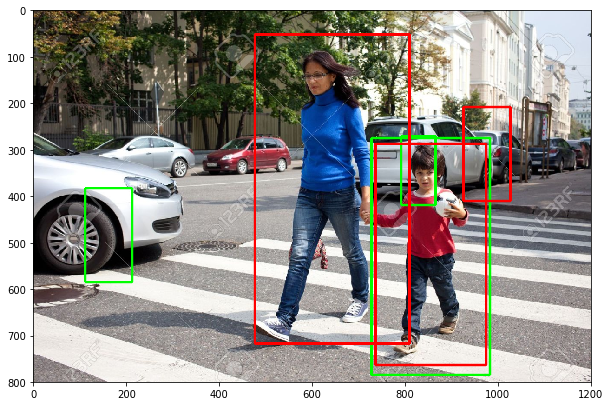

processing: ../resource/lib/publicdata/images/pedestrians/4.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 3


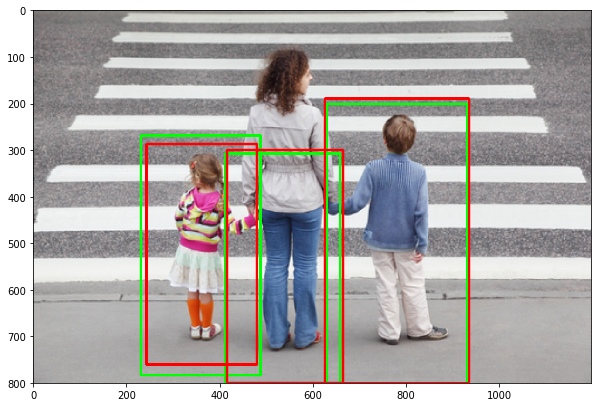

processing: ../resource/lib/publicdata/images/pedestrians/5.jpg
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 4


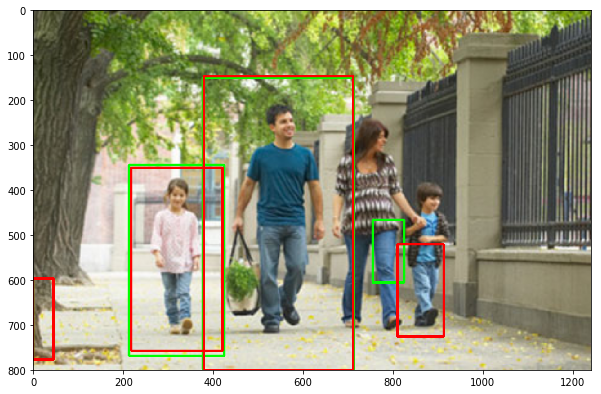

processing: ../resource/lib/publicdata/images/pedestrians/3.jpg
Trained Detector :: pedestrians detected: 2
Default Detector :: pedestrians detected: 2


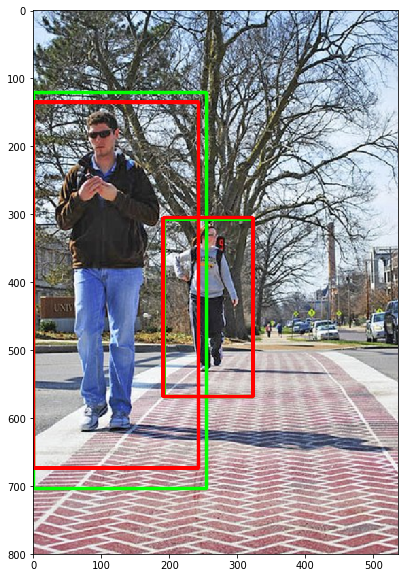

processing: ../resource/lib/publicdata/images/pedestrians/race.jpg
Trained Detector :: pedestrians detected: 9
Default Detector :: pedestrians detected: 10


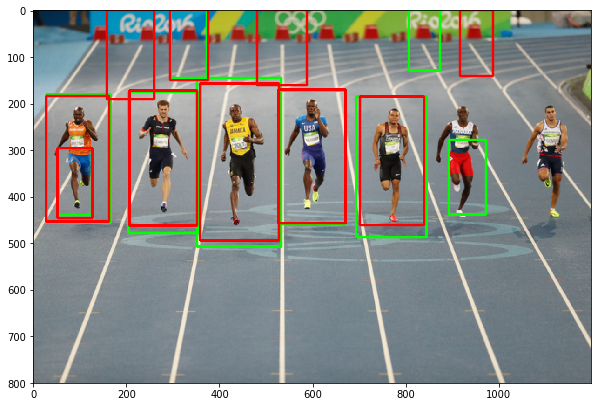

processing: ../resource/lib/publicdata/images/pedestrians/1.jpg
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 6


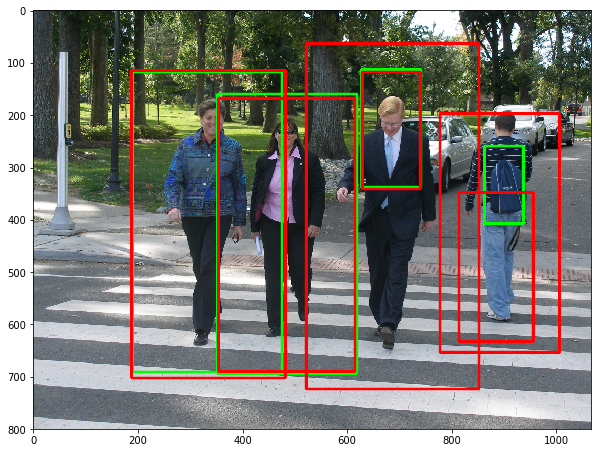

In [21]:
# read images from pedestrians directory
imageDir = DATA_PATH + 'images/pedestrians'
imagePaths = glob.glob(os.path.join(imageDir, '*.jpg'))

# We will run pedestrian detector at an fixed height image
finalHeight = 800.0

for imagePath in imagePaths:
    print('processing: {}'.format(imagePath))

    # read image
    im = cv2.imread(imagePath, cv2.IMREAD_COLOR)

    # resize image to height finalHeight
    scale = finalHeight / im.shape[0]
    im = cv2.resize(im, None, fx=scale, fy=scale)
    
    # Detect people using trained and default SVM detectors
    # detectMultiScale using detector trained by us
    bboxes, weights = hog.detectMultiScale(im, winStride=(8, 8),
                                    padding=(32, 32),scale=1.05, 
                                    finalThreshold=2,hitThreshold=1.0)

    # detectMultiScale using default detector
    bboxes2, weights2 = hogDefault.detectMultiScale(im, winStride=(8, 8), 
                                padding=(32, 32),scale=1.05, 
                                finalThreshold=2,hitThreshold=0)
    
    # Draw found rectangles on image. We will draw 
    # green boxes for people detected by trained model and 
    # red boxes for people detected by OpenCV’s default model.
    # print pedestrians detected
    if len(bboxes) > 0:
        print('Trained Detector :: pedestrians detected: {}'
                .format(bboxes.shape[0]))
    if len(bboxes2) > 0:
        print('Default Detector :: pedestrians detected: {}'
                .format(bboxes2.shape[0]))

    # Draw detected bouunding boxes over image
    # Red = default detector, Green = Trained Detector
    for bbox in bboxes:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2), 
                      (0, 255, 0), thickness=3, 
                      lineType=cv2.LINE_AA)

    for bbox in bboxes2:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2), 
                      (0, 0, 255), thickness=3, 
                      lineType=cv2.LINE_AA)
    # Finally show the result and also write it to disk.
    # Show final result
    plt.imshow(im[:,:,::-1])
    # Write image to disk
    imResultPath = os.path.join('results', os.path.basename(imagePath))
    cv2.imwrite(imResultPath, im)
    plt.show()

### Hard Negative Mining

You may have noticed that our model produces slightly more False Positives. It is because we haven’t done negative mining. For negative mining you just have to run this detector on negative images ( You can download some images which do not contain persons). 

The model is giving false positives because it is finding it difficult to predict these patches correctly. So, we want to train it on some difficult examples. This is also called Hard Negative mining.

When you run the detector on full negative images, write all those patches ( bbox ) which are predicted as positive (i.e. predicted label = 1) into a directory (let’s call it falsePosPatches). Make sure that you resize this patch to 64x128 before writing to falsePosPatches directory.

Now train the model again this time with images in posPatches as positive images and images in negPatches + falsePosPatches as negative images.

# References and Further Reading

1. [https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)

3. [https://en.wikipedia.org/wiki/Support_vector_machine](https://en.wikipedia.org/wiki/Support_vector_machine)

4. [http://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/](http://www.pyimagesearch.com/2015/11/09/pedestrian-detection-opencv/)

5. http://blog.dlib.net/2014/02/dlib-186-released-make-your-own-object.html